# GenAI 데이터 분석 - 비트코인 역사적 데이터

이 과제에서는 LangChain과 OpenAI API를 활용하여 비트코인 데이터셋을 탐색하고 분석합니다. 데이터 전처리, 기본 통계 분석, 시각화 등을 통해 데이터의 주요 특징을 파악합니다.

## 발급 받은 OpenAI key를 불러옵니다.

In [1]:
import os

os.environ["OPENAI_API_KEY"] = ""

## 1. 데이터 로드 및 LangChain Agent 설정

비트코인 데이터셋을 불러오고, LangChain Agent를 생성하여 데이터를 요약하고 분석하는 데 사용할 준비를 합니다.

### 2024년 9월 3일부터 2024년 11월 1일까지의 비트코인 역사적 가격 데이터 분석해보겠습니다. (출처: https://coinmarketcap.com/currencies/bitcoin/historical-data/)

In [6]:
# 필요한 라이브러리 불러오기
import pandas as pd
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI

# 데이터 로드
# read_csv() 참고: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
# delimiter: 데이터 구분자. 데이터가 ';'으로 구분되어 있으므로 delimiter=';'로 설정합니다.
df = pd.read_csv('../data/Bitcoin_Historical_Data_Sept-Nov_2024.csv', delimiter=';')

# LangChain의 Chat 모델 및 DataFrame Agent 생성
# ChatOpenAI: OpenAI API를 사용하여 자연어 처리를 수행하는 Chat 모델입니다.
# ChatOpenAI() 참고: https://python.langchain.com/docs/integrations/chat/openai/#invocation
chat = ChatOpenAI(model_name="gpt-4o-mini")
# create_pandas_dataframe_agent(): Chat 모델과 데이터프레임을 연결하여 데이터 분석을 수행하는 Agent를 생성합니다.
# create_pandas_dataframe_agent() 참고: https://python.langchain.com/api_reference/experimental/agents/langchain_experimental.agents.agent_toolkits.pandas.base.create_pandas_dataframe_agent.html
# create_pandas_dataframe_agent()의 주요 매개변수:
# - llm 인자: agent가 사용할 Chat 모델입니다. 이 경우, 위에서 생성한 chat 모델을 사용합니다.
# - df 인자: 분석할 데이터프레임입니다. 이 경우, 위에서 불러온 df 데이터프레임을 사용합니다.
# - allow_dangerous_code 인자: 위험한 코드를 실행할 수 있는지 여부를 설정합니다. 이 경우, True로 설정합니다.
# TODO: create_pandas_dataframe_agent() 함수 속 올바른 인자들을 채워주세요.
agent = create_pandas_dataframe_agent(llm=chat,df=df, allow_dangerous_code=True)


In [7]:
# tpye() 함수를 사용하여 데이터프레임의 타입을 확인합니다. 이를 통해 데이터프레임이 잘 불러와졌는지 확인할 수 있습니다.
type(df)

pandas.core.frame.DataFrame

## 2. 데이터 요약 정보 요청

LangChain Agent를 사용하여 데이터셋의 기본 통계량과 주요 정보를 요약합니다.

In [15]:
# 데이터 요약 정보 추출
# invoke(): Agent에게 요청을 보내고 결과를 반환합니다.
# invoke 함수를 사용하여 Pandas DataFrame에 대한 다양한 질문 참고: https://python.langchain.com/v0.1/docs/integrations/toolkits/pandas/#multi-dataframe-example
# TODO: agent에게 요청을 보내고 결과를 반환하는 함수를 작성해주세요.
summary = agent.invoke("이 데이터프레임의 기본 통계 요약을 제공해 주세요.")
# invoke() 함수를 사용해 반환한 결과를 출력해서, 데이터프레임의 기본 통계 요약을 확인합니다.
summary

{'input': '이 데이터프레임의 기본 통계 요약을 제공해 주세요.',
 'output': 'The summary statistics of the DataFrame `df` will include count, mean, standard deviation, min, 25th percentile, median, 75th percentile, and max for the numeric columns: `open`, `high`, `low`, `close`, `volume`, and `marketCap`.'}

## 3. 결측치 처리
데이터프레임 내 결측치가 있는지 확인하고, 앞의 값으로 채우는 방식으로 결측치를 처리합니다.

In [9]:
# ffill()함수: 결측치를 앞의 값으로 채우는 함수입니다.
# 이 문제에선 결측치를 앞의 값으로 채우기 위해 ffill() 함수를 사용합니다.
# ffill() 함수 참고: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ffill.html
# inplace=True:  결측치를 채운 후 데이터프레임을 업데이트하기 위해 inplace=True로 설정합니다.
df.ffill(inplace=True)

## 4. 날짜 형식 변환

`timeOpen`과 `timeClose` 컬럼의 형식을 datetime으로 변환하여 날짜 데이터를 다룰 준비를 합니다.

In [10]:
# 날짜 형식 변환
# to_datetime() 함수:  다양한 형식의 날짜/시간 데이터를 pandas의 datetime 객체로 변환하는 데 사용되는 함수
# 이 문제에선 'timeOpen'과 'timeClose' 컬럼의 데이터를 datetime 형식으로 변환합니다.
# to_datetime() 함수 참고: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
df['timeOpen'] = pd.to_datetime(df['timeOpen'])
df['timeClose'] = pd.to_datetime(df['timeClose'])


## 5. 불필요한 컬럼 제거
데이터 분석에 중복되는 `timestamp` 컬럼을 제거하여 데이터프레임을 정리합니다.

In [11]:
# 불필요한 컬럼 제거
# drop() 함수: 데이터프레임에서 특정 컬럼을 제거하는 함수
# 이 문제에선 'timestamp' 컬럼을 제거합니다.
df.drop(columns=['timestamp'], inplace=True)

## 6. 주요 데이터 항목 EDA
LangChain Agent를 사용하여 거래량이 높은 상위 5일의 데이터를 탐색합니다.

In [12]:
# 상위 거래량 5일 데이터 추출
# 이 문제에선 가장 높은 거래량을 기록한 상위 5일의 데이터를 추출하기 위해 invoke() 함수를 사용합니다.
# TODO: agent에게 요청을 보내고 결과를 반환하는 함수를 작성해주세요.
top_volume_days = agent.invoke("가장 높은 거래량을 기록한 상위 5일의 데이터를 보여주세요.")
top_volume_days

{'input': '가장 높은 거래량을 기록한 상위 5일의 데이터를 보여주세요.',
 'output': '```\n|    | timeOpen                        | timeClose                       | timeHigh                   | timeLow                    |   name |          open |          high |          low |         close |        volume |      marketCap |\n|---:|:-------------------------|:-------------------------|:-------------------------|:-------------------------|-------:|----------------|----------------|----------------|----------------|----------------|----------------|\n|  3 | 2024-10-29 00:00:00+00:00 | 2024-10-29 23:59:59.999000+00:00 | 2024-10-29T19:12:00.000Z | 2024-10-29T00:11:00.000Z |   2781 |  69910.045366 |  73577.209658 |  69729.917830 |  72720.493575 |  5.854187e+10 |  1.437942e+12 |\n|  31 | 2024-10-01 00:00:00+00:00 | 2024-10-01 23:59:59.999000+00:00 | 2024-10-01T07:40:00.000Z | 2024-10-01T20:42:00.000Z |   2781 |  63335.603584 |  64110.981999 |  60189.278697 |  60837.009701 |  5.022092e+10 |  1.202222e+12 |\n|  0 | 20

## 7. 종가 변동 시각화
비트코인의 일별 `close` 가격 변동을 시각화하여 전반적인 추세를 파악합니다.

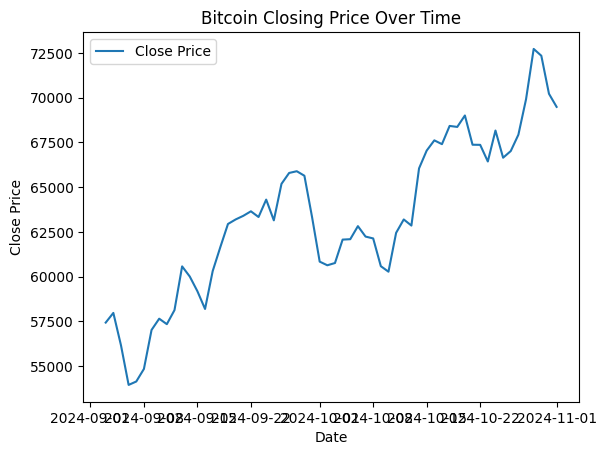

In [13]:
import matplotlib.pyplot as plt

# 종가 변동 시각화
# 이 문제에선 'timeOpen'과 'close' 컬럼을 사용하여 종가 변동을 시각화합니다.
# plot() 함수: 데이터 시각화를 위해 사용되는 함수
plt.plot(df['timeOpen'], df['close'], label="Close Price")
# title(): 그래프의 제목을 설정하는 함수
plt.title('Bitcoin Closing Price Over Time')
# xlabel(): x축의 레이블을 설정하는 함수
plt.xlabel('Date')
# ylabel(): y축의 레이블을 설정하는 함수
plt.ylabel('Close Price')
# legend(): 그래프의 범례를 설정하는 함수
plt.legend()
# show(): 그래프를 화면에 출력하는 함수
plt.show()

## 8. 거래량 변동 시각화
일별 `volume` 변동을 시각화하여 비트코인 거래량의 변동성을 파악합니다.

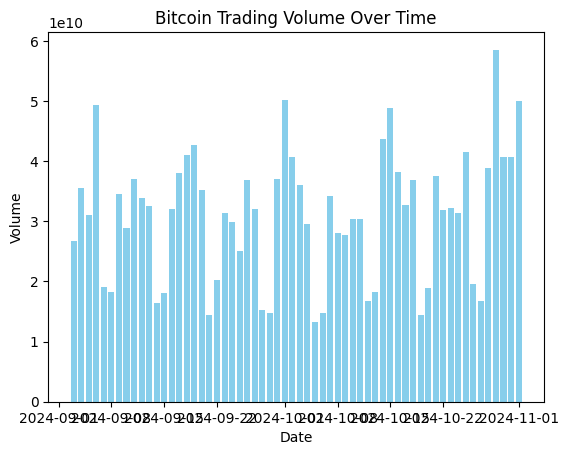

In [14]:
# 거래량 변동 시각화
# 이 문제에선 'timeOpen'과 'volume' 컬럼을 사용하여 거래량 변동을 시각화합니다.
# bar() 함수: 막대 그래프를 그리는 함수
plt.bar(df['timeOpen'], df['volume'], color='skyblue')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()